# Tensorflow实现Word2Vec模型
数据分析与预处理
在本节中，我们将定义一些函数，使我们能够构建一个良好的Word2Vec模型。对于这个实现，我们将使用一个清理过的版本
维基百科（维基百科是一个网络百科全书项目，特点是自由内容、自由编辑。它目前是全球网络上最大且最受大众欢迎的参考工具书，名列全球十大最受欢迎的网站）。
因此，让我们从导入这个实现所需的包开始:

In [1]:
import numpy as np  #导入NumPy函数库且别名np
import tensorflow as tf #导入tensorflow且别名tf

In [2]:
import matplotlib.pyplot as plt #（导入绘图工具并别名plt）matplotlib.pyplot是一个有命令风格的函数集合，各种状态通过函数调用保存起来，以便于可以随时跟踪像当前图像和绘图区域这样的东西
from sklearn.manifold import TSNE #从sklearn.manifoldz中导入TSNE算法  sklearn已经封装了大量的机器学习算法，包括LIBSVM和LIBINEAR。同时sklearn内置了大量数据集，节省了获取和整理数据集的时间

In [3]:
#用于下载数据集的包
from urllib.request import urlretrieve  #导入urlretrieve函数
from os.path import isfile, isdir #从Python的os.path模块中导入了 isdir() 和 isfile()函数
from tqdm import tqdm #使用tqdm显示进度条
import zipfile #导入zipfile模块 -单独压缩/解压文件

In [4]:
#用于数据预处理的包
import re #导入re模块，方便直接调用来实现正则匹配
from collections import Counter #从collections模块导入counter工具，用于支持便捷和快速地计数
import random #导入random模块

接下来，我们将定义一个类，如果之前没有下载数据集，它将用于下载数据集:

In [5]:
# 在这个实现中，我们将使用来自MA的维基百科的清理版本。
# 因此，我们将定义一个帮助下载数据集的助手类。
wiki_dataset_folder_path = 'wikipedia_data'#维基数据集的文件夹路径
wiki_dataset_filename = 'text8.zip' #维基数据集的文件名
wiki_dataset_name = 'Text8 Dataset'  #维基数据集的名称

In [6]:
class DLProgress(tqdm):
    last_block = 0   # 继承tqdm类

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num   
#定义钩子函数：就是我们自己实现的函数，函数类型与挂载点匹配
#self调用相应的更新数据以及模块#block_num=1：已经下载的数据块=1， block_size=1：数据块的大小=1，total_size=None：远程文件的大小为空
#self在定义时需要定义，但是在调用时会自动传入。
#self的名字并不是规定死的，但是最好还是按照约定是用self
#self总是指调用时的类的实例。

In [7]:
if not isfile(wiki_dataset_filename):  # 如果文件尚未下载，请停止
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=wiki_dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            wiki_dataset_filename,
            pbar.hook)#用url索引以下网址下载text8文件

In [8]:
# 现在检查数据是否已被提取
if not isdir(wiki_dataset_folder_path):#如果不提取它
    with zipfile.ZipFile(wiki_dataset_filename) as zip_ref:
        zip_ref.extractall(wiki_dataset_folder_path)#则zip_ref作为维基数据文件名；维基文件夹路径改为 zip_ref.extractall

In [9]:
with open('wikipedia_data/text8') as f:
    cleaned_wikipedia_text = f.read()  #打开wikipedia_data/text8数据且别名f，将f赋值清理过的维基文本

我们可以看看这个数据集的前100个字符:
接下来，我们将对文本进行预处理，因此我们将定义一个助手函数
这将帮助我们将诸如标点符号之类的特殊字符替换为已知令牌。
另外，为了减少输入文本中的噪音，您可能需要删除文本中不经常出现的单词:

In [10]:
def preprocess_text(input_text):
    # 用一些特殊符号替换标点符号，这样我们就可以在模型中使用标点符号。
    input_text = input_text.lower()
    input_text = input_text.replace('.', ' <PERIOD> ')
    input_text = input_text.replace(',', ' <COMMA> ')
    input_text = input_text.replace('"', ' <QUOTATION_MARK> ')
    input_text = input_text.replace(';', ' <SEMICOLON> ')
    input_text = input_text.replace('!', ' <EXCLAMATION_MARK> ')
    input_text = input_text.replace('?', ' <QUESTION_MARK> ')
    input_text = input_text.replace('(', ' <LEFT_PAREN> ')
    input_text = input_text.replace(')', ' <RIGHT_PAREN> ')
    input_text = input_text.replace('--', ' <HYPHENS> ')
    input_text = input_text.replace('?', ' <QUESTION_MARK> ')

    input_text = input_text.replace(':', ' <COLON> ')
    text_words = input_text.split()
     # 忽略所有出现五个词的单词
    text_word_counts = Counter(text_words)
    trimmed_words = [word for word in text_words if text_word_counts[word] > 5]

    return trimmed_words

现在，让我们在输入文本上调用这个函数并查看输出:
让我们看看我们有多少词和不同的词，为预处理版本的文本:

In [11]:
print('Preprocessing the text')#打印（预处理文本…）
preprocessed_words = preprocess_text(cleaned_wikipedia_text)

print("Total number of words in the text: {}".format(len(preprocessed_words)))#打印文本中的单词总数
print("Total number of unique words in the text: {}".format(len(set(preprocessed_words))))#打印文本中唯一单词的总数

Preprocessing the text...
Total number of words in the text: 16680599
Total number of unique words in the text: 63641


这里，我在创建字典来将单词转换成整数，整数按降序分配，因此最常用的单词(the) 是整数，其次是最常用的gets，依此类推。这些单词被转换为整数并存储在列表中。

正如在本节前面提到的，我们需要使用单词的整数索引在权重矩阵中查找它们的值，因此我们将使用单词to integers和integers单词。这将帮助我们查找单词，也得到具体的单词索引。例如，输入文本中重复次数最多的单词将在位置0处建立索引，其次是重复次数第二多的单词，依此类推。

那么，让我们定义一个函数来创建这个查找表:


In [12]:
def create_lookuptables(input_words):#定义函数创建查找表
    """
    Creating lookup tables for vocan

    Function arguments:
    param words: Input list of words
    """
    input_word_counts = Counter(input_words)
    sorted_vocab = sorted(input_word_counts, key=input_word_counts.get, reverse=True)
    integer_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_integer = {word: ii for ii, word in integer_to_vocab.items()}

    # 返回一组二进制文件
    return vocab_to_integer, integer_to_vocab

现在，让我们调用已定义的函数来创建查找表:

In [13]:
print('Creating the lookup table...')
vocab_to_integer, integer_to_vocab = create_lookuptables(preprocessed_words)
integer_words = [vocab_to_integer[word] for word in preprocessed_words]

Creating the lookup table...


为了建立一个更精确的模型，我们可以删除不太改变上下文的单词，如of, for, the等等。因此，实践证明我们可以建立更精确的
模型的同时丢弃这些类型的词。从上下文中删除与上下文无关的单词的过程称为子抽样。为了定义单词丢弃的通用机制，Mikolov引入了一个计算某个单词丢弃概率的函数：
P(Wi)=1-√(t/f(Wi)) 
t是单词丢弃参数
f(wi)是输入数据集中特定目标字wi的频率

因此，我们将实现一个助手函数，它将计算数据集中每个单词的丢弃概率p(wi):

In [14]:
print('Subsampling...')#打印（“子采样…”）
# 去除无益词汇
word_threshold = 1e-5

Subsampling...


In [15]:
word_counts = Counter(integer_words) #将整数字计总并赋值单词数计数
total_number_words = len(integer_words)#将整数词的长度赋值总计单词的数目

In [16]:
#计算单词的频率
frequencies = {word: count/total_number_words for word, count in word_counts.items()}

In [17]:
#计算丢弃概率的总数
prob_drop = {word: 1 - np.sqrt(word_threshold/frequencies[word]) for word in word_counts}
training_words = [word for word in integer_words if random.random() < (1 - prob_drop[word])]

与其平等对待所有上下文相关的单词，我们将为那些离目标单词有点远的单词分配更少的权重。例如，如果我们选择窗口为C = 4，然后我们将从1到C的范围中选择一个随机数L，然后从当前单词的历史和未来中抽取L单词样本。现在我们来定义这个函数

In [18]:
#定义在特定窗口中返回特定索引周围的单词的函数
def get_target(input_words, ind, context_window_size=5):
    # 从当前单词的历史和特征中选择用于生成单词的随机数
    rnd_num = np.random.randint(1, context_window_size + 1)
    start_ind = ind - rnd_num if (ind - rnd_num) > 0 else 0
    stop_ind = ind + rnd_num

    target_words = set(input_words[start_ind:ind] + input_words[ind + 1:stop_ind + 1])

    return list(target_words)

另外，让我们定义一个生成器函数，从训练样本中生成一个随机的批处理，并得到该批处理中每个单词的上下文单词:

In [19]:
#定义一个函数来生成词批作为元组（输入，目标）
def generate_random_batches(input_words, train_batch_size, context_window_size=5):
    num_batches = len(input_words) // train_batch_size
    #Python 有两种除法操作符，一种是单斜杠：用于传统除法，另一种双斜杠：用于浮点数除法，其结果进行四舍五入。
    #举例：5//2=2（2.5向负无穷方向取整为2），同时-5//2=-3（-2.5向负无穷方向取整为-3）

#处理全部批次
    input_words = input_words[:num_batches * train_batch_size]

    for ind in range(0, len(input_words), train_batch_size):
        input_vals, target = [], []
        input_batch = input_words[ind:ind + train_batch_size]

        # 获取每个单词的上下文
        for ii in range(len(input_batch)):
            batch_input_vals = input_batch[ii]
            batch_target = get_target(input_batch, ii, context_window_size)

            target.extend(batch_target)
            input_vals.extend([batch_input_vals] * len(batch_target))
        yield input_vals, target
train_graph = tf.Graph()

我们将使用一个嵌入层来学习这些单词的一个特殊实值表示。因此，这些词将以one-hot 向量的形式出现。其思想是训练这个网络来建立权重矩阵。那么，让我们从创建模型的输入开始:
另外，我们不需要自己实现查找函数，因为它已经实现了
在Tensorflow可用: tf.nn.embedding  lookup()。因此，它将使用整数编码，并在权重矩阵中找到相应的行。权重矩阵将从均匀分布中随机初始化:

In [20]:
with train_graph.as_default():
    inputs_values = tf.placeholder(tf.int32, [None], name='inputs_values')
    labels_values = tf.placeholder(tf.int32, [None, None], name='labels_values')

num_vocab = len(integer_to_vocab)#这是我们试图构建的权重或嵌入矩阵将具有以下形状:

num_embedding = 300

In [21]:
with train_graph.as_default():
    embedding_layer = tf.Variable(tf.random_uniform((num_vocab, num_embedding), -1, 1))

    # 接下来，我们将使用Tf.n.EngtudioLoopUp函数获取隐藏层的输出。
    embed_tensors = tf.nn.embedding_lookup(embedding_layer, inputs_values)

# 样本负标签数
num_sampled = 100

In [22]:
with train_graph.as_default():
    # 创建SoftMax权值和偏差
    softmax_weights = tf.Variable(tf.truncated_normal((num_vocab, num_embedding)))
    softmax_biases = tf.Variable(tf.zeros(num_vocab), name="softmax_bias")

    # 用负抽样法计算模型损失
    model_loss = tf.nn.sampled_softmax_loss(
        weights=softmax_weights,#权重
        biases=softmax_biases,#偏差
        labels=labels_values,#分类
        inputs=embed_tensors,#输入
        num_sampled=num_sampled,#训练时用来做负样本的噪声单词数量
        num_classse=num_vocab)#类别数量

    model_cost = tf.reduce_mean(model_loss)#模型损失
    model_optimizer = tf.train.AdamOptimizer().minimize(model_cost)#模型优化

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



为了验证我们的训练模型，我们将取样一些常见的或常见的词和一些不常见的词，并尝试打印我们的最接近的词集基于学习了skip-gram体系结构的表示:

In [23]:
with train_graph.as_default():
    # 相似性评价中的随机词集
    valid_num_words = 16 #有效单词数是16
    valid_window = 100   #有效窗口数是100

    #从（0100）和（10001100）每个范围选取8个样本。低ID意味着更频繁
    valid_samples = np.array(random.sample(range(valid_window), valid_num_words // 2))
    valid_samples = np.append(valid_samples,
                              random.sample(range(1000, 1000 + valid_window), valid_num_words // 2))

    valid_dataset_samples = tf.constant(valid_samples, dtype=tf.int32)

    # 余弦距离的计算
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding_layer), 1, keep_dims=True))
    normalized_embed = embedding_layer / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embed, valid_dataset_samples)
    cosine_similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embed))
    #现在，我们已经为我们的模型准备好了所有的细节，我们准备开始训练过程。
    #让我们开始培训过程:
num_epochs = 10 #表示把所有的数据过10遍
train_batch_size = 1000 #训练批次大小为1000
contextual_window_size = 10 #窗口大小为10

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [24]:
with train_graph.as_default():
    saver = tf.train.Saver() #用于保存模型，以后再用就可以直接导入模型进行计算，方便。

In [25]:
with tf.Session(graph=train_graph) as sess:
    #创建一个新的tensorflow的session，并指定了训练计算图
    iteration_num = 1 #迭代次数为1
    average_loss = 0 #平均损失为0

    sess.run(tf.global_variables_initializer())#初始化模型的参数

    for e in range(1, num_epochs + 1):

        # 生成随机批量训练
        batches = generate_random_batches(training_words, train_batch_size, contextual_window_size)

        # 迭代批处理样本
        for input_vals, target in batches:

            # 创建使用feed_dict将数据投入到训练损失中
            feed_dict = {inputs_values: input_vals,
                         labels_values: np.array(target)[:, None]}

            train_loss, _ = sess.run([model_cost, model_optimizer], feed_dict=feed_dict)

            # 定义后平均损失=前平均损失+训练损失
            average_loss += train_loss

            # 100次迭代后打印结果
            if iteration_num % 100 == 0: #这里的%取余数
                print("Epoch Number {}/{}".format(e, num_epochs),
                      "Iteration Number: {}".format(iteration_num),
                      "Avg. Training loss: {:.4f}".format(average_loss / 100))
                average_loss = 0

            if iteration_num % 1000 == 0:

                # 用余弦相似度求单词的最近单词
                similarity = cosine_similarity.eval()
                for i in range(valid_num_words):
                    valid_word = integer_to_vocab[valid_samples[i]]

                    # 最近邻居数
                    top_k = 8
                    nearest_words = (-similarity[i, :]).argsort()[1:top_k + 1]
                    msg = 'The nearest to %s:' % valid_word
                    for k in range(top_k):
                        similar_word = integer_to_vocab[nearest_words[k]]
                        msg = '%s %s,' % (msg, similar_word)
                    print(msg)

            iteration_num += 1 
    save_path = saver.save(sess, "checkpoints/cleaned_wikipedia_version.ckpt")
    embed_mat = sess.run(normalized_embed)
    #运行上述代码片段10个epoch后，您将得到以下输出:


Epoch Number 1/10 Iteration Number: 100 Avg. Training loss: 21.6604
Epoch Number 1/10 Iteration Number: 200 Avg. Training loss: 21.4402
Epoch Number 1/10 Iteration Number: 300 Avg. Training loss: 21.2084
Epoch Number 1/10 Iteration Number: 400 Avg. Training loss: 21.1050
Epoch Number 1/10 Iteration Number: 500 Avg. Training loss: 20.9704
Epoch Number 1/10 Iteration Number: 600 Avg. Training loss: 20.8201
Epoch Number 1/10 Iteration Number: 700 Avg. Training loss: 20.6866
Epoch Number 1/10 Iteration Number: 800 Avg. Training loss: 20.5438
Epoch Number 1/10 Iteration Number: 900 Avg. Training loss: 20.3951
Epoch Number 1/10 Iteration Number: 1000 Avg. Training loss: 20.2697
The nearest to when: belvedere, disposal, blackmore, realvideo, frederic, alkaloid, inprise, rgensen,
The nearest to with: antagonism, joaquin, ignited, iix, symbolics, dealbata, landowners, goldsworthy,
The nearest to during: kipsigis, pluto, overrode, cortot, complained, econometrics, sewing, trinity,
The nearest to

我们可以很明显的看到，随着迭代次数的不断增加，训练损失值在不断的下降，可以看到我们的训练的模型对名词、动词、形容词等类型的单词的相似词汇的识别是非常精确的。因此由skip-gram word2vec得到的向量空间表达是非常高质量的，近义词在向量空间上的位置也是非常接近的。为了帮助我们更清楚地了解嵌入矩阵，我们将使用维数缩减技术，如TSNE，来降低实值向量到二维，然后我们把它们形象化用对应的词标记每个点:

INFO:tensorflow:Restoring parameters from checkpoints\cleaned_wikipedia_version.ckpt


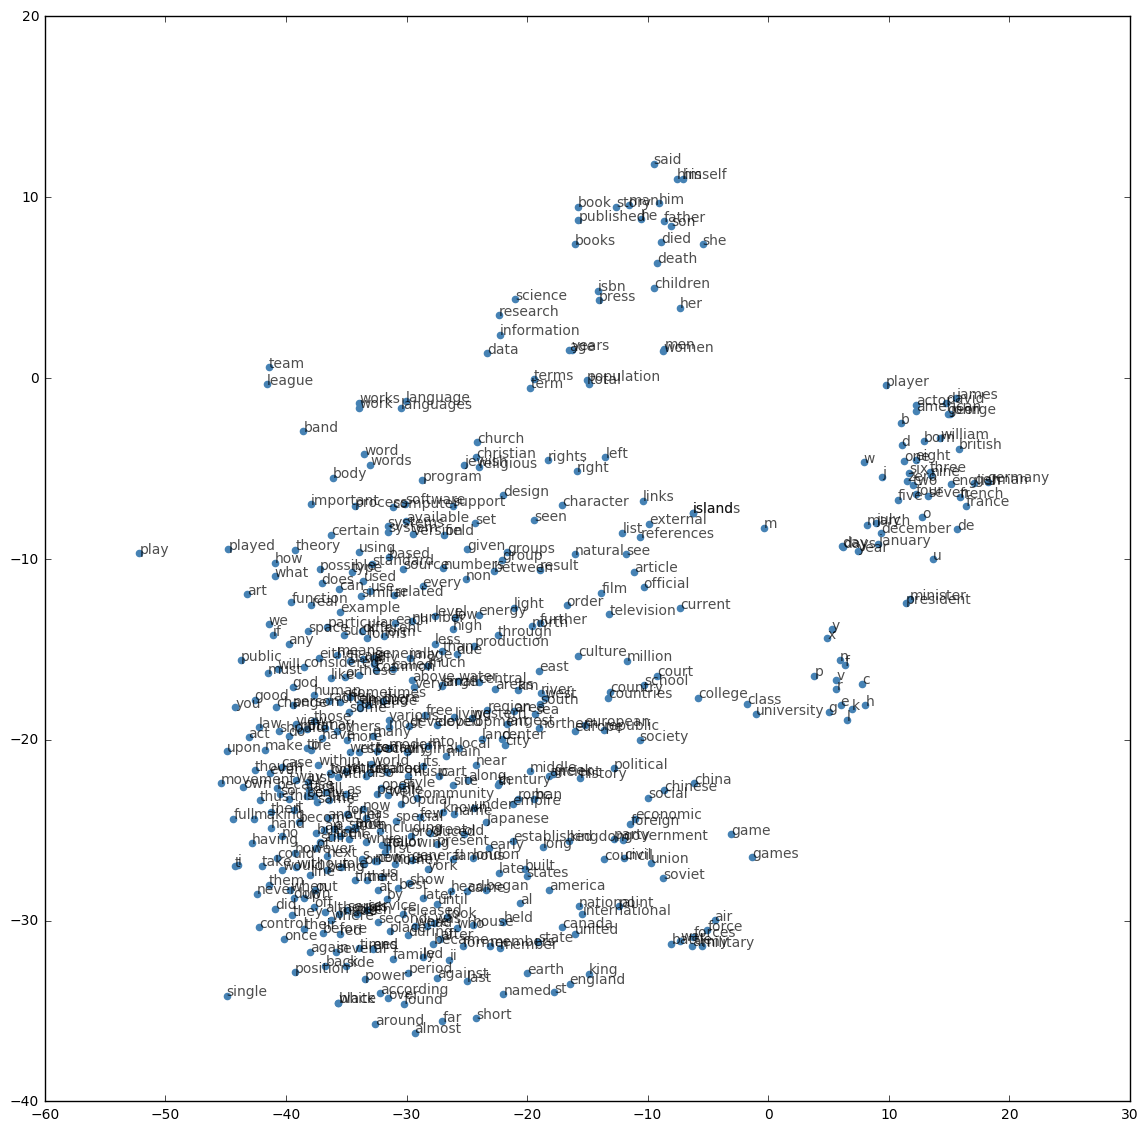

In [27]:
%matplotlib inline #内嵌画图
with train_graph.as_default():
    saver = tf.train.Saver() #首先定义一个Saver类
#定义会话
with tf.Session(graph=train_graph) as sess:
    #创建一个新的tensorflow的session，并指定了训练计算图
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    #用saver类来保存和恢复变量
    embedding_matrix = sess.run(embedding_layer)#定义嵌入矩阵

num_visualize_words = 500 #这里形象化的展示词频最高的500个单词
tsne_obj = TSNE()#使用TSNE实现降维
embedding_tsne = tsne_obj.fit_transform(embedding_matrix[:num_visualize_words, :])
#将原始的嵌入向量降至2维
fig, ax = plt.subplots(figsize=(14, 14))#设置宽度和高度为14*14
for ind in range(num_visualize_words):#选取抽中的500单词
    plt.scatter(*embedding_tsne[ind, :], color='steelblue')#画散点图 ，并设置铁青色颜色
    plt.annotate(integer_to_vocab[ind], (embedding_tsne[ind, 0], embedding_tsne[ind, 1]), alpha=0.7)
    #添加注释，注释每个点代表的单词名称

从上面的可视化效果我们可以很明显的看到，其中距离近相近的单词在语义上具有很高的相似性。例如：game和games很相近，但是和China就很远。
代码总结：我们介绍了将单词转换为实值向量Word2Vec所采用的一种技术，这种技术具有非常有趣的特性,例如本次代码实现的意思相近的词在向量空间中的位置会比较接近。
